Skema ERD Database Sumber Sebagai berikut:
<br/><img src="images/skema_erd_database.png" alt="Skema ERD" width="100%" height="auto">

# Utilities Function

In [2]:
import pandas as pd
def uniqueValues(df: pd.DataFrame): 
  cols = df.select_dtypes(exclude=['int64','float64']).columns
  for col in cols:
      print(f"Len {col}: {len(df[col].unique().tolist())}") # unique values
      print(f"{col}: {df[col].unique().tolist()}\n")

In [ ]:
df = pd.read_csv("csv/orders.csv", sep=";")
display(df.shape) # (110, 17) [Data transaksi memenuhi prasyarat min. 100 data]
df.head()

(110, 17)

,id,status,currency,type,tax_amount,total_amount,customer_id,billing_email,date_created_gmt,date_updated_gmt,parent_order_id,payment_method,payment_method_title,transaction_id,ip_address,user_agent,customer_note
0,1036,wc-processing,IDR,shop_order,"0,00000000","62700,00000000",62,mgreallyo@quantcast.com,2025-05-08 22:36:36,2025-05-08 22:36:37,0,cod,Cash on delivery,NaN,118.99.118.196,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,NaN
1,1037,wc-processing,IDR,shop_order,"0,00000000","329000,00000000",63,enernp@weibo.com,2025-05-08 22:53:26,2025-05-08 22:53:26,0,cod,Cash on delivery,NaN,118.99.118.196,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,NaN
2,1038,wc-processing,IDR,shop_order,"0,00000000","550000,00000000",64,rlangfatq@istockphoto.com,2025-05-08 22:56:25,2025-05-08 22:56:25,0,cod,Cash on delivery,NaN,118.99.118.196,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,NaN
3,1039,wc-processing,IDR,shop_order,"0,00000000","159000,00000000",65,akorneichikr@quantcast.com,2025-05-08 22:59:51,2025-05-08 22:59:52,0,cod,Cash on delivery,NaN,118.99.118.196,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,NaN
4,1040,wc-processing,IDR,shop_order,"0,00000000","160000,00000000",66,ggerards@instagram.com,2025-05-08 23:02:06,2025-05-08 23:02:06,0,cod,Cash on delivery,NaN,118.99.118.196,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,NaN


# Exploratory Data Analysis (EDA)

Menjawab Pertanyaan-Pertanyaan Berikut:
- Total Pelanggan? Total terjadinya Transaksi? Total Nilai Uang seluruh Transaksi?
- Pelanggan Yang paling banyak melakukan Transaksi?
- Pepbelian Produk Terbanyak? Pembelian Termahal?
- Distribusi Pembelian Tiap Daerah (bar chart)? Trend Pembelian Tiap Daerah? Barang apa yang paling sering dibeli di tiap daerah? 
- Pembelian dari tiap ip address

## Setup Dataset

Menggunakan **fact_sales_v1.csv** yang merincikan detail sampai jumlah qty untuk masing-masing produk pada tiap transaksi. Query penggabungan Tabel sebagai berikut:
```
SELECT 
    o.id AS order_id,
    o.date_created_gmt as order_date,
    o.ip_address,
    o.total_amount,
    c.customer_id,
    c.first_name,
    c.last_name,
    c.email,
    c.country,
    c.city,
    c.state,
    oi.order_item_name,
	 oi.order_item_type,
    op.product_qty
FROM wpkr_wc_orders o
INNER JOIN wpkr_wc_customer_lookup c ON o.customer_id = c.customer_id
INNER JOIN wpkr_woocommerce_order_items oi ON o.id = oi.order_id
LEFT JOIN wpkr_wc_order_product_lookup op ON o.id = op.order_id;
```

In [ ]:
import pandas as pd
df = pd.read_csv('csv/fact_sales_v1.csv', sep=';')
print(f"DF: {df.shape[0]} rows x {df.shape[1]} columns")
display(df.info())
display(df.head())
display(df.describe().T) # T for Transpose

print(df.duplicated().sum()) # 452 duplicate
print(df.isna().sum()) # no missing value

DF: 766 rows x 14 columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 766 entries, 0 to 765
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   order_id         766 non-null    int64 
 1   order_date       766 non-null    object
 2   ip_address       766 non-null    object
 3   total_amount     766 non-null    object
 4   customer_id      766 non-null    int64 
 5   first_name       766 non-null    object
 6   last_name        766 non-null    object
 7   email            766 non-null    object
 8   country          766 non-null    object
 9   city             766 non-null    object
 10  state            766 non-null    object
 11  order_item_name  766 non-null    object
 12  order_item_type  766 non-null    object
 13  product_qty      766 non-null    int64 
dtypes: int64(3), object(11)
memory usage: 83.9+ KB


None

,order_id,order_date,ip_address,total_amount,customer_id,first_name,last_name,email,country,city,state,order_item_name,order_item_type,product_qty
0,1036,2025-05-08 22:36:36,118.99.118.196,"62700,00000000",62,Vaclav,Wedge,vwedge1s@typepad.com,ID,Malang,JI,Atasan Basic Wanita,line_item,1
1,1036,2025-05-08 22:36:36,118.99.118.196,"62700,00000000",62,Vaclav,Wedge,vwedge1s@typepad.com,ID,Malang,JI,Free shipping,shipping,1
2,1037,2025-05-08 22:53:26,118.99.118.196,"329000,00000000",63,Ysabel,Grimster,ygrimster1h@timesonline.co.uk,ID,Samarinda,KI,This Is April Atasan Kemeja Lengan Panjang,line_item,1
3,1037,2025-05-08 22:53:26,118.99.118.196,"329000,00000000",63,Ysabel,Grimster,ygrimster1h@timesonline.co.uk,ID,Samarinda,KI,Free shipping,shipping,1
4,1038,2025-05-08 22:56:25,118.99.118.196,"550000,00000000",64,Olive,O'Logan,oologanc@imgur.com,ID,Kota Pontianak,KB,AMOENE [MADE] Long Strap Dress Navy,line_item,1


,count,mean,std,min,25%,50%,75%,max
order_id,766.0,1118.550914,33.906166,1036.0,1103.0,1109.0,1153.0,1181.0
customer_id,766.0,68.383812,29.088038,14.0,48.0,60.0,100.0,109.0
product_qty,766.0,1.018277,0.152299,1.0,1.0,1.0,1.0,3.0


452
order_id           0
order_date         0
ip_address         0
total_amount       0
customer_id        0
first_name         0
last_name          0
email              0
country            0
city               0
state              0
order_item_name    0
order_item_type    0
product_qty        0
dtype: int64


In [6]:
uniqueValues(df)

Len order_date: 110
order_date: ['2025-05-08 22:36:36', '2025-05-08 22:53:26', '2025-05-08 22:56:25', '2025-05-08 22:59:51', '2025-05-08 23:02:06', '2025-05-08 23:10:21', '2025-05-08 23:12:14', '2025-05-08 23:19:30', '2025-05-08 23:23:15', '2025-05-08 23:25:58', '2025-05-08 23:28:35', '2025-05-08 23:30:49', '2025-05-09 14:08:55', '2025-05-09 14:14:17', '2025-05-09 14:17:37', '2025-05-09 14:20:17', '2025-05-09 14:23:08', '2025-05-09 14:26:15', '2025-05-09 14:28:54', '2025-05-09 14:31:28', '2025-05-09 14:34:08', '2025-05-09 14:36:31', '2025-05-09 14:39:27', '2025-05-09 14:41:49', '2025-05-09 15:25:46', '2025-05-09 15:34:35', '2025-05-09 15:37:30', '2025-05-09 15:39:17', '2025-05-09 15:41:10', '2025-05-09 15:42:53', '2025-05-09 15:44:29', '2025-05-09 15:46:05', '2025-05-09 15:48:01', '2025-05-09 15:49:50', '2025-05-09 15:51:23', '2025-05-09 15:53:50', '2025-05-09 16:31:12', '2025-05-09 16:34:01', '2025-05-09 16:38:41', '2025-05-09 16:48:14', '2025-05-09 16:50:32', '2025-05-09 16:53:57', '

In [8]:

df2 = df.copy()
# Preprocess
df2 = df2[df2['order_item_type'] != 'shipping']
# Ganti koma jadi titik, ubah ke float
df2['total_amount'] = df2['total_amount'].str.replace(',', '.').astype(float)
# Format agar nol di belakang koma hilang, misal: 151900.0 -> 151900
df2['total_amount'] = df2['total_amount'].map(lambda x: int(x) if x.is_integer() else x)
df2['order_date'] = pd.to_datetime(df2['order_date'])
df2["customer_name"] = df2["first_name"] + " " + df2["last_name"]

df2.drop(columns=['country', 'order_item_type', 'first_name', 'last_name'], inplace=True)

# Ubah urutan kolom agar full_name menjadi yang pertama
df2 = df2[["order_id", "order_date", "ip_address", "total_amount", "customer_id", "customer_name", "email", "state", "city", "order_item_name", "product_qty"]]

print(f"DF Clean: {df2.shape[0]} rows x {df2.shape[1]} columns")
df2.info()
df2.head(20)

DF Clean: 566 rows x 11 columns
<class 'pandas.core.frame.DataFrame'>
Index: 566 entries, 0 to 764
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   order_id         566 non-null    int64         
 1   order_date       566 non-null    datetime64[ns]
 2   ip_address       566 non-null    object        
 3   total_amount     566 non-null    int64         
 4   customer_id      566 non-null    int64         
 5   customer_name    566 non-null    object        
 6   email            566 non-null    object        
 7   state            566 non-null    object        
 8   city             566 non-null    object        
 9   order_item_name  566 non-null    object        
 10  product_qty      566 non-null    int64         
dtypes: datetime64[ns](1), int64(4), object(6)
memory usage: 53.1+ KB


,order_id,order_date,ip_address,total_amount,customer_id,customer_name,email,state,city,order_item_name,product_qty
0,1036,2025-05-08 22:36:36,118.99.118.196,62700,62,Vaclav Wedge,vwedge1s@typepad.com,JI,Malang,Atasan Basic Wanita,1
2,1037,2025-05-08 22:53:26,118.99.118.196,329000,63,Ysabel Grimster,ygrimster1h@timesonline.co.uk,KI,Samarinda,This Is April Atasan Kemeja Lengan Panjang,1
4,1038,2025-05-08 22:56:25,118.99.118.196,550000,64,Olive O'Logan,oologanc@imgur.com,KB,Kota Pontianak,AMOENE [MADE] Long Strap Dress Navy,1
6,1039,2025-05-08 22:59:51,118.99.118.196,159000,65,Joanie Mannie,jmanniee@google.com.au,KB,Kota Pontianak,Point One NINDY Khaki Tunik Dress,1
8,1040,2025-05-08 23:02:06,118.99.118.196,160000,66,Klarrisa Calender,kcalenderf@shinystat.com,KB,Kota Pontianak,Hosofshopaholic - Darel Skirt,1
10,1041,2025-05-08 23:10:21,118.99.118.196,44900,67,Corrina Clubb,cclubbh@marketwatch.com,KB,Kota Pontianak,ORO PANTS,1
12,1042,2025-05-08 23:12:14,118.99.118.196,160000,68,Rodge Winram,rwinrami@cnn.com,KB,Kota Pontianak,Hosofshopaholic - Darel Skirt,1
14,1043,2025-05-08 23:19:30,118.99.118.196,379000,69,Ronny Plews,rplewsj@paypal.com,KB,Kota Pontianak,This Is April Rok Midi Crochet Wanita,1
16,1044,2025-05-08 23:23:15,118.99.118.196,379000,70,Isis Griss,igrissk@addtoany.com,KB,Kota Pontianak,This Is April Rok Midi Crochet Wanita,1
18,1045,2025-05-08 23:25:58,118.99.118.196,52000,71,Rita Crownshaw,rcrownshawl@cnet.com,KB,Kota Pontianak,Baju Atasan Lengan Pendek Wanita,1


In [8]:
# Kelompokkan order berdasarkan order_id dan gabungkan item dalam list
df_grouped = df2.groupby("order_id").agg({
    "order_date": "first", # (diambil dari order pertama)
    "customer_id": "first", 
    "customer_name": "first", 
    "order_item_name": list,  # Gabungkan daftar produk dalam list
    "total_amount": "first"  
}).reset_index()

display(df_grouped.shape)
# Hitung jumlah item per order
df_grouped["total_items"] = df_grouped["order_item_name"].apply(len)
df_grouped.sample(30)
# # Seleksi order dengan jumlah item terbanyak
# order_max_items = df_grouped.sort_values(by="total_items", ascending=False).iloc[0]

# order_max_items['order_item_name']

(110, 6)

,order_id,order_date,customer_id,customer_name,order_item_name,total_amount,total_items
105,1177,2025-05-10 08:01:50,93,Yolanda Ewenson,[SHOEBALI Heels 021-218],215000,1
41,1086,2025-05-09 16:53:57,47,Aliza Aguilar,"[Sweater Hoodie Pria Oldskull Misty, Sweater N...",381000,4
13,1050,2025-05-09 14:14:17,28,Jessy De Bell,[ORO PANTS],44900,1
84,1156,2025-05-10 06:32:18,109,Blythe Aspinal,[Tas Sekolah Tas Anak Tk Paud Cartoon Excavato...,472800,9
102,1174,2025-05-10 07:50:35,90,Benton Farrance,[HEELSADDICT Mini Amber Laser Cut Sling Bag],93400,1
11,1047,2025-05-08 23:30:49,73,Norah Armfield,[This Is April Atasan Kemeja Lengan Panjang],329000,1
12,1049,2025-05-09 14:08:55,23,Swen Wittman,[AMOENE [MADE] Long Strap Dress Navy],550000,1
16,1053,2025-05-09 14:23:08,39,Rollins Pascho,[Celana korduroi pinggang tinggi],86601,1
34,1078,2025-05-09 15:51:23,37,Kelcey Ziehms,[Zipper Hoodie Dewasa Polos],149000,1
40,1085,2025-05-09 16:50:32,43,Dinnie Tambling,[Jam Tangan Pria Kulit],749000,1


In [207]:
df_grouped2 = df2.groupby(["order_id", "order_item_name"]).agg({
    "customer_id": "first",  # Nama customer tetap diambil dari order pertama
    "order_date": "first",  # Tanggal order diambil dari yang pertama
    "total_amount": "first",
    "order_item_name": "count"  # Menghitung jumlah (qty) tiap produk dalam order
}).rename(columns={"order_item_name": "qty"}).reset_index()

display(df_grouped2.describe().T) # nilai right skewed
df_grouped2.head(20)


,count,mean,min,25%,50%,75%,max,std
order_id,200.0,1116.615,1036.0,1088.0,1109.0,1156.0,1181.0,39.72679
customer_id,200.0,69.93,14.0,48.0,66.5,100.0,109.0,29.691802
order_date,200,2025-05-10 00:42:39.994999808,2025-05-08 22:36:36,2025-05-09 16:59:00,2025-05-10 04:34:28,2025-05-10 06:32:18,2025-05-10 08:17:14,NaN
total_amount,200.0,608314.045,20580.0,200019.0,473000.0,857300.0,2064000.0,485022.921448
qty,200.0,2.83,1.0,1.0,3.0,4.0,7.0,1.790848


,order_id,order_item_name,customer_id,order_date,total_amount,qty
0,1036,Atasan Basic Wanita,62,2025-05-08 22:36:36,62700,1
1,1037,This Is April Atasan Kemeja Lengan Panjang,63,2025-05-08 22:53:26,329000,1
2,1038,AMOENE [MADE] Long Strap Dress Navy,64,2025-05-08 22:56:25,550000,1
3,1039,Point One NINDY Khaki Tunik Dress,65,2025-05-08 22:59:51,159000,1
4,1040,Hosofshopaholic - Darel Skirt,66,2025-05-08 23:02:06,160000,1
5,1041,ORO PANTS,67,2025-05-08 23:10:21,44900,1
6,1042,Hosofshopaholic - Darel Skirt,68,2025-05-08 23:12:14,160000,1
7,1043,This Is April Rok Midi Crochet Wanita,69,2025-05-08 23:19:30,379000,1
8,1044,This Is April Rok Midi Crochet Wanita,70,2025-05-08 23:23:15,379000,1
9,1045,Baju Atasan Lengan Pendek Wanita,71,2025-05-08 23:25:58,52000,1


In [238]:
customer_counts = df2.groupby(["customer_id", "email"]).agg({
    "customer_name": "first",  
    "product_qty": "count" 
}).rename(columns={"product_qty": "total_orders"}).reset_index()
customer_counts

,customer_id,email,customer_name,total_orders
0,14,fpreshawg@china.com.cn,Fairlie Preshaw,1
1,15,dbrideaux27@mit.edu,Danyelle Brideaux,9
2,16,abeall25@mtv.com,Ambrosius Beall,1
3,19,mgreallyo@quantcast.com,Marlene Greally,16
4,20,rlangfatq@istockphoto.com,Roma Langfat,1
...,...,...,...,...
89,105,manger1u@blog.com,Malva Anger,22
90,106,hclayson1v@yahoo.com,Harcourt Clayson,5
91,107,mrandal1w@latimes.com,Morgana Randal,13
92,108,akirkup1x@parallels.com,Alix Kirkup,13


## Visualisasi: Distribusi Customer

In [63]:
# df2[ df2['total_amount'] == df2['total_amount'].max()]

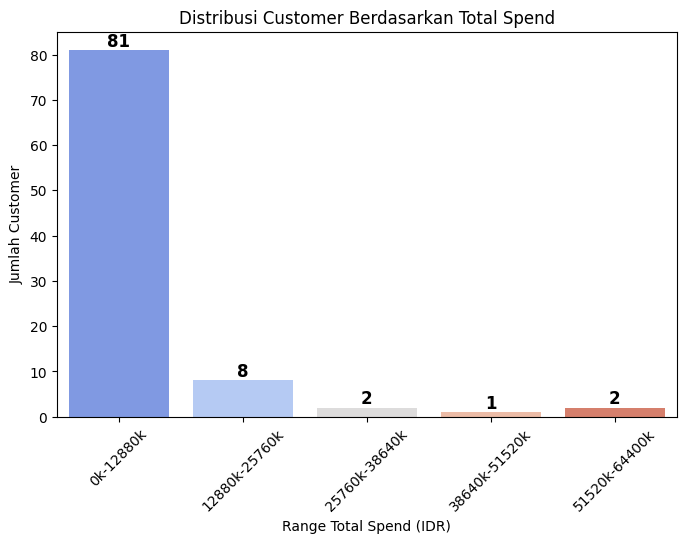

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

customer_sales = df2.groupby("customer_name")["total_amount"].sum().reset_index()
customer_sales.columns = ["customer_name", "total_spent"]

# Input nilai maksimum dan jumlah kategori
max_value = math.ceil(customer_sales['total_spent'].max() / 100000) * 100000

num_categories = 5

# Buat rentang nilai secara otomatis
bins = np.linspace(0, max_value, num_categories + 1)

# Format label agar lebih mudah dibaca
labels = [f"{int(bins[i]/1000)}k-{int(bins[i+1]/1000)}k" for i in range(len(bins)-1)]

customer_sales["spend_category"] = pd.cut(customer_sales["total_spent"], bins=bins, labels=labels, right=True)

# Hitung jumlah customer di setiap kategori
spend_distribution = customer_sales["spend_category"].value_counts().sort_index()

# Buat figure dan plot
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=spend_distribution.index, y=spend_distribution.values, palette="coolwarm", hue=spend_distribution.index)

# Tambahkan label nominal pada masing-masing batang
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

# Konfigurasi tampilan
plt.xlabel("Range Total Spend (IDR)")
plt.ylabel("Jumlah Customer")
plt.title("Distribusi Customer Berdasarkan Total Spend")
plt.xticks(rotation=45)
plt.show()

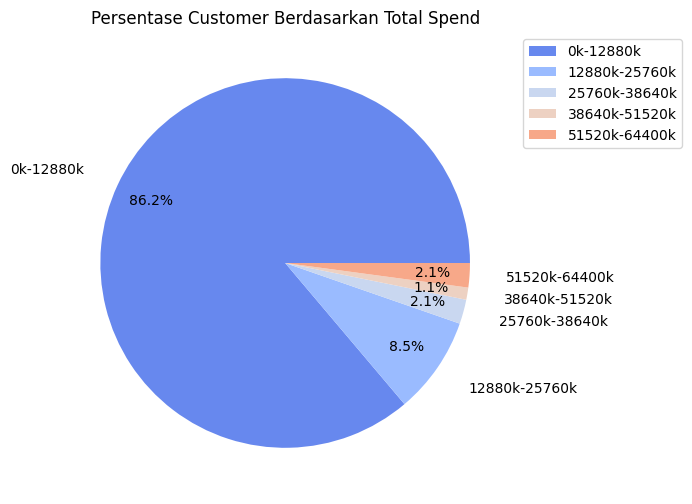

In [54]:
plt.figure(figsize=(6, 6))

# Buat pie chart dengan penyesuaian posisi label
plt.pie(
    spend_distribution, 
    labels=spend_distribution.index, 
    autopct="%1.1f%%",
    colors=sns.color_palette("coolwarm"),
    labeldistance=1.2,  # Memindahkan label lebih jauh dari lingkaran
    pctdistance=0.8  # Memindahkan persentase ke bagian dalam
)

plt.title("Persentase Customer Berdasarkan Total Spend")

# Tambahkan legend agar label tidak saling berdekatan
plt.legend(spend_distribution.index, loc="best", bbox_to_anchor=(1, 1))

plt.show()

In [ ]:
# spend_distribution.to_csv("spend_distribution.csv", index=True) # Model disimpan untuk digunakan di dasboard

## Geomap: Pembelian per Kota (by Shafa)

In [3]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import plotly.express as px

# Load data
df = pd.read_csv("csv/fact_sales_v2.csv", sep=';', encoding='utf-8')
df['city'] = df['city'].str.replace(r'^(Kota|Kabupaten)\s+', '', case=False, regex=True).str.strip()
df = df[df['city'].notnull() & (df['city'] != '')]

unique_orders = df[['order_id', 'city']].drop_duplicates()
city_transaction_counts = unique_orders['city'].value_counts().reset_index()
city_transaction_counts.columns = ['city', 'transaction_count']

most_bought_items = (
    df.groupby(['city', 'order_item_name'])
    .size()
    .reset_index(name='count')
    .sort_values(['city', 'count'], ascending=[True, False])
    .drop_duplicates('city')
    .rename(columns={'order_item_name': 'most_bought_product'})
)

city_sales = pd.merge(city_transaction_counts, most_bought_items[['city', 'most_bought_product']], on='city', how='left')
geolocator = Nominatim(user_agent="myApp", timeout=10)
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

def safe_geocode(city):
    try:
        return geocode(f"{city}, Indonesia")
    except:
        return None

city_sales['location'] = city_sales['city'].apply(safe_geocode)
city_sales['latitude'] = city_sales['location'].apply(lambda loc: loc.latitude if loc else None)
city_sales['longitude'] = city_sales['location'].apply(lambda loc: loc.longitude if loc else None)

# Hapus baris tanpa koordinat
city_sales = city_sales.dropna(subset=['latitude', 'longitude'])

# === PLOT ===
fig = px.scatter_geo(
    city_sales,
    lat='latitude',
    lon='longitude',
    size='transaction_count',
    color_discrete_sequence=['red'],  # Titik warna merah
    hover_name='city',
    hover_data={
        'transaction_count': True,
        'most_bought_product': True,
        'latitude': False,
        'longitude': False
    },
    title='Sebaran Transaksi per Kota',
    projection='mercator'
)

fig.update_geos(
    visible=True,
    lataxis_range=[-11, 6],
    lonaxis_range=[95, 141],
    showcountries=True,
    countrycolor="Black"
)

fig.update_layout(
    margin={"r": 0, "t": 30, "l": 0, "b": 0},
    legend_title_text='Jumlah Transaksi'
)

fig.show()

## Bar chart: Pembelian per Kota (by Hanif)

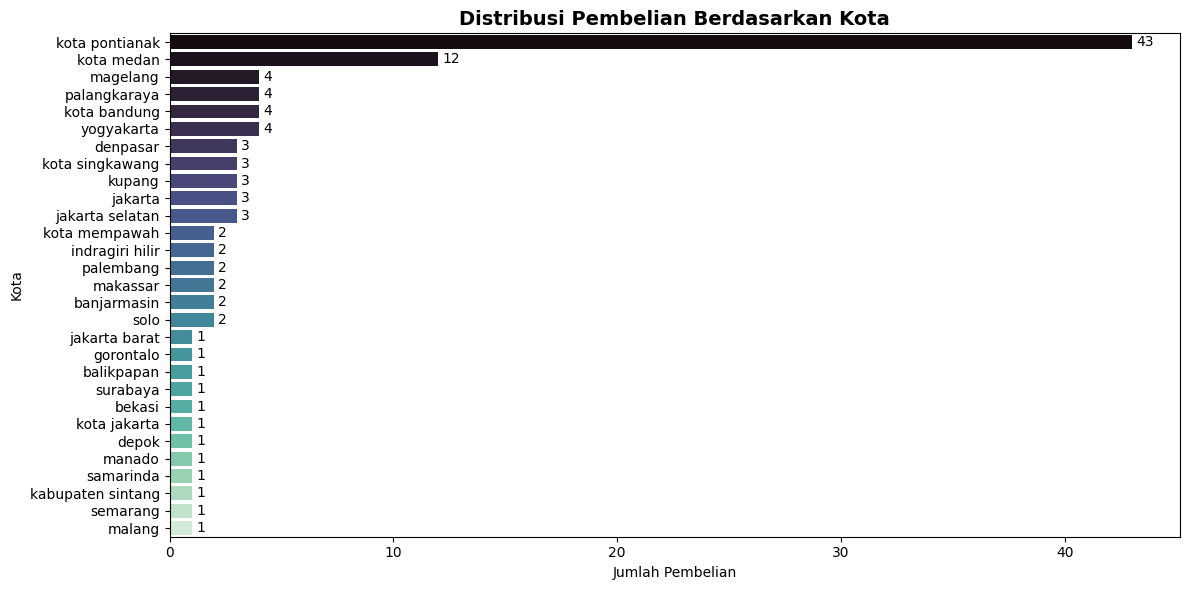

In [6]:
# import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
fact_sales = pd.read_csv("csv/fact_sales_v1.csv", sep=";")

# Filter hanya produk
filtered_sales = fact_sales[fact_sales["order_item_type"] == "line_item"].copy()

# Normalisasi nama kota (gabungkan yang mirip)
filtered_sales['city'] = filtered_sales['city'].str.lower().str.strip()
filtered_sales['city'] = filtered_sales['city'].replace({
    'pontianak': 'kota pontianak',
    'medan': 'kota medan',
    'bandung': 'kota bandung',
    'singkawang' : 'kota singkawang'
    # Tambahkan sesuai kebutuhan
})

# Ambil data unik per order_id dan kota
unique_orders_by_city = filtered_sales[['order_id', 'city']].drop_duplicates()

# Hitung jumlah pembelian unik per kota
city_sales = unique_orders_by_city['city'].value_counts().reset_index()
city_sales.columns = ["city", "jumlah_pembelian"]

# Visualisasi
plt.figure(figsize=(12, 6))
plot = sns.barplot(data=city_sales, x="jumlah_pembelian", y="city", palette="mako", hue="city")

# Tambahkan label
for i in plot.containers:
    plot.bar_label(i, fmt='%d', label_type='edge', padding=3)

plt.title("Distribusi Pembelian Berdasarkan Kota", fontsize=14, fontweight="bold")
plt.xlabel("Jumlah Pembelian")
plt.ylabel("Kota")
plt.tight_layout()
plt.show()

## Bar Chart: Most Interacted product (by Hanif)

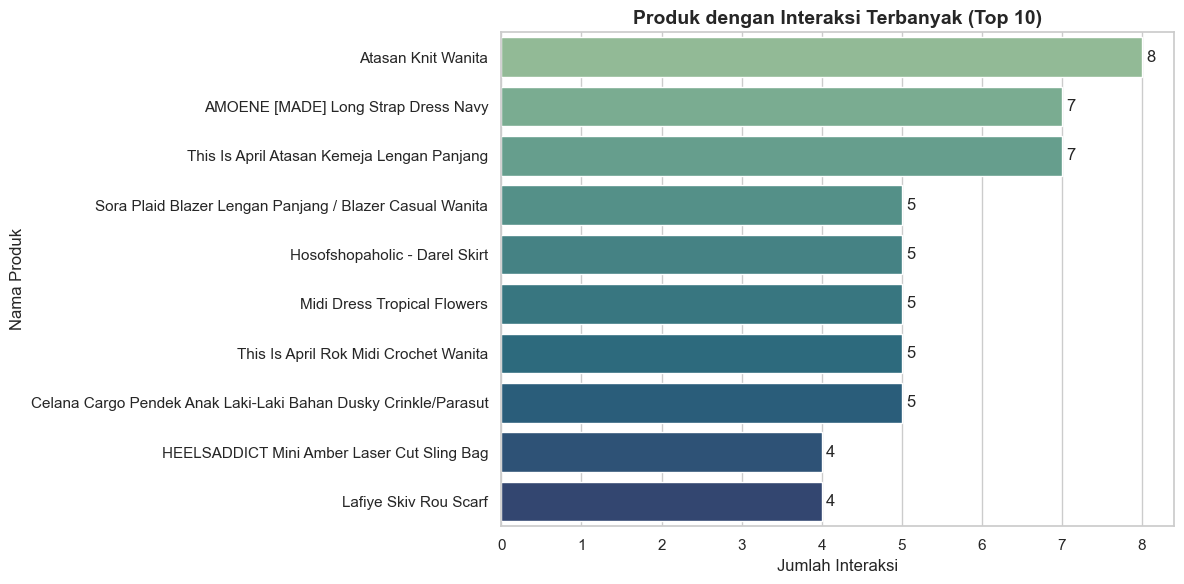

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns


# Load ulang file order_items
order_items = pd.read_csv("csv/order_items.csv", sep=";")

# Filter data hanya untuk interaksi produk (line_item)
product_interactions = order_items[order_items["order_item_type"] == "line_item"]

# Hitung jumlah interaksi per produk
product_counts = product_interactions["order_item_name"].value_counts().reset_index()
product_counts.columns = ["product_name", "interaction_count"]


# Ambil 10 produk dengan interaksi terbanyak
top_products = product_counts.head(10)

# Visualisasi
plt.figure(figsize=(12, 6))
plot = sns.barplot(data=top_products, x="interaction_count", y="product_name", palette="crest", hue="product_name", legend=False)

# Tambahkan label angka
for bar in plot.containers:
    plot.bar_label(bar, fmt='%d', label_type='edge', padding=3)

plt.title("Produk dengan Interaksi Terbanyak (Top 10)", fontsize=14, fontweight="bold")
plt.xlabel("Jumlah Interaksi")
plt.ylabel("Nama Produk")
plt.tight_layout()
plt.show()

## Line Chart: Transaction by IP Address (by Nashya)

<Figure size 1800x800 with 0 Axes>

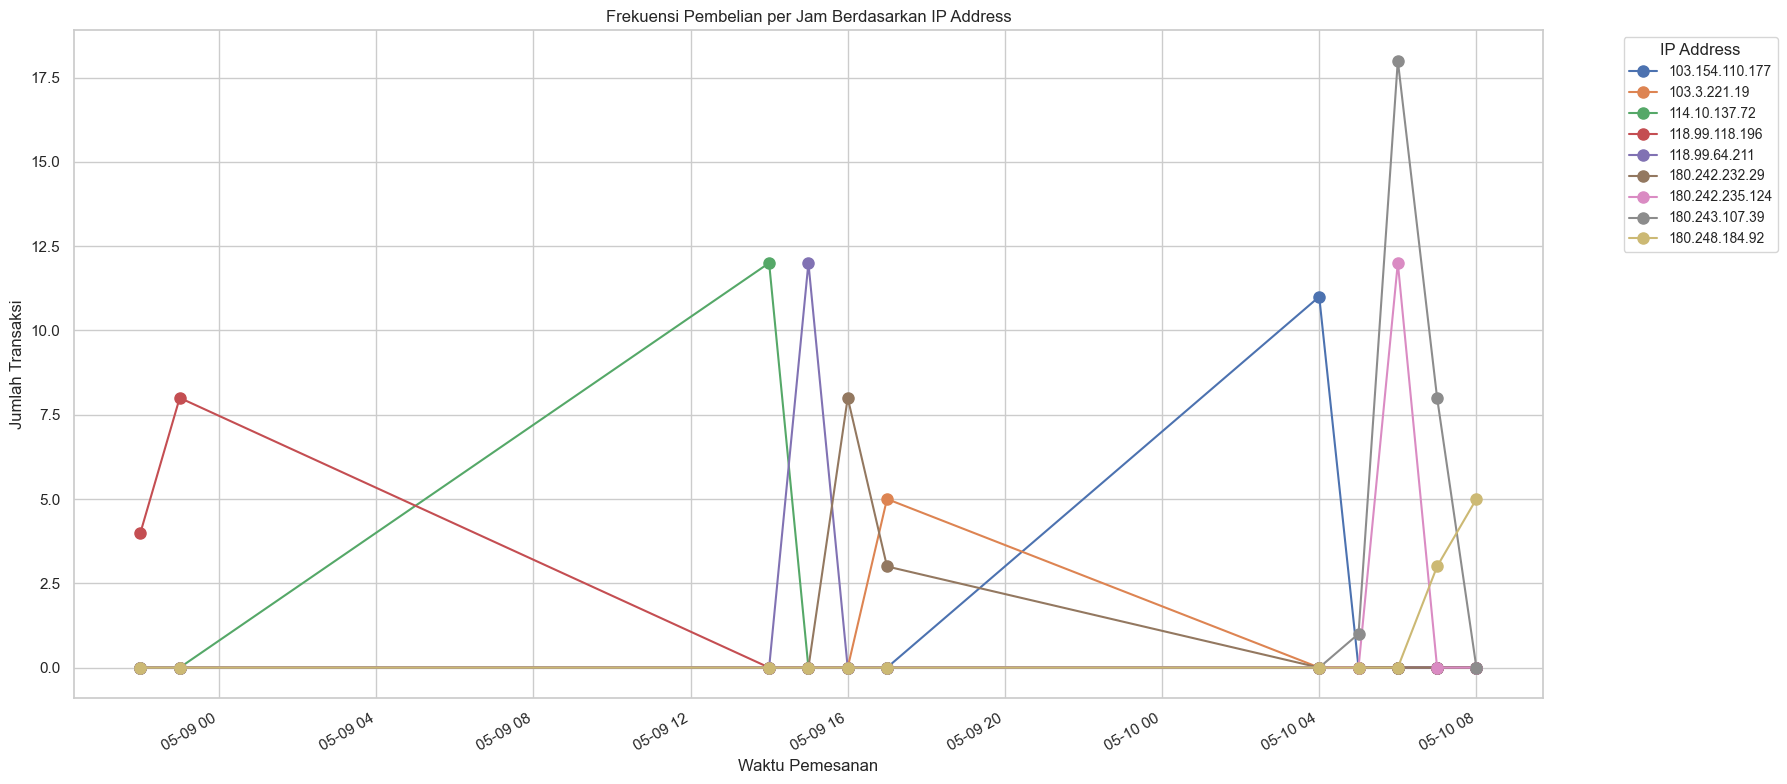

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('csv/fact_sales_v1.csv', sep=';')

# Bersihkan data
df = df[df['order_item_type'] != 'shipping']
df['order_date'] = pd.to_datetime(df['order_date'])
df = df[['order_date', 'ip_address', 'order_id']].drop_duplicates()

# Group berdasarkan jam dan IP
df['order_time'] = df['order_date'].dt.floor('h')  # bulatkan ke jam terdekat
grouped = df.groupby(['order_time', 'ip_address']).size().reset_index(name='jumlah_transaksi')

# Pivot
pivot_df = grouped.pivot(index='order_time', columns='ip_address', values='jumlah_transaksi').fillna(0)

# Plot
plt.figure(figsize=(18, 8))
pivot_df.plot(marker='o', markersize=8, linewidth=1.5, figsize=(18, 8))
plt.title('Frekuensi Pembelian per Jam Berdasarkan IP Address')
plt.xlabel('Waktu Pemesanan')
plt.ylabel('Jumlah Transaksi')
plt.legend(title='IP Address', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.grid(True)
plt.show()

# Model: Aturan Asosiasi
Cocok untuk Association Rule Mining jika:
- Kolom order_id → digunakan untuk mengelompokkan transaksi.
- Kolom order_item_name → berisi produk yang dibeli.
- Setiap baris adalah item dalam sebuah transaksi.

## Setup Dataset

Menggunakan **fact_sales_v2.csv** yang memiliki detail produk dari tiap transaksi (walau tidak merincikan qty masing-masing produk). Query-nya sebagai berikut:
```
SELECT
    o.id AS order_id,
    o.date_created_gmt AS order_date,
    o.total_amount,
    op.product_id,
    oi.order_item_name,
    p.total_sales,
	 oi.order_item_type,
    op.product_qty,
    op.product_net_revenue,
    op.shipping_amount,
    c.customer_id,
    c.first_name,
    c.last_name,
    c.email,
    c.country,
    c.city,
    c.state,
    p.sku,
    p.average_rating

FROM wpkr_wc_order_product_lookup op

-- Join ke orders
JOIN wpkr_wc_orders o ON o.id = op.order_id

-- Join ke item name
JOIN wpkr_woocommerce_order_items oi ON oi.order_id = o.id
    AND oi.order_item_id = op.order_item_id

-- Join ke customer
JOIN wpkr_wc_customer_lookup c ON c.customer_id = op.customer_id

-- Join ke product meta
LEFT JOIN wpkr_wc_product_meta_lookup p ON p.product_id = op.product_id

-- Optional: join alamat
-- LEFT JOIN wpkr_wc_order_addresses a ON a.order_id = o.id AND a.address_type = 'billing'

-- Produk tanpa shipping
WHERE oi.order_item_type = 'line_item'

ORDER BY o.date_created_gmt DESC;

```

In [9]:
import pandas as pd
df = pd.read_csv('csv/fact_sales_v2.csv', sep=';')
print(f"DF: {df.shape[0]} rows x {df.shape[1]} columns")
display(df.info()) # tipe data sesuai (object bisa diubah ke category)
display(df.head())
display(df.describe().T) # nilai right skewed

print(df.duplicated().sum()) # no duplicate
print(df.isna().sum()) # no missing value

DF: 200 rows x 19 columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   order_id             200 non-null    int64 
 1   order_date           200 non-null    object
 2   total_amount         200 non-null    object
 3   product_id           200 non-null    int64 
 4   order_item_name      200 non-null    object
 5   total_sales          200 non-null    int64 
 6   order_item_type      200 non-null    object
 7   product_qty          200 non-null    int64 
 8   product_net_revenue  200 non-null    int64 
 9   shipping_amount      200 non-null    int64 
 10  customer_id          200 non-null    int64 
 11  first_name           200 non-null    object
 12  last_name            200 non-null    object
 13  email                200 non-null    object
 14  country              200 non-null    object
 15  city                 200 non-nu

None

,order_id,order_date,total_amount,product_id,order_item_name,total_sales,order_item_type,product_qty,product_net_revenue,shipping_amount,customer_id,first_name,last_name,email,country,city,state,sku,average_rating
0,1036,2025-05-08 22:36:36,"62700,00000000",565,Atasan Basic Wanita,2,line_item,1,62700,0,19,Marlene,Greally,mgreallyo@quantcast.com,ID,Pontianak,KB,NaN,"0,00"
1,1037,2025-05-08 22:53:26,"329000,00000000",1020,This Is April Atasan Kemeja Lengan Panjang,8,line_item,1,329000,0,24,Eberto,Nern,enernp@weibo.com,ID,Pontianak,KB,NaN,"0,00"
2,1038,2025-05-08 22:56:25,"550000,00000000",1019,AMOENE [MADE] Long Strap Dress Navy,8,line_item,1,550000,0,20,Roma,Langfat,rlangfatq@istockphoto.com,ID,Kota Singkawang,KB,NaN,"0,00"
3,1039,2025-05-08 22:59:51,"159000,00000000",1015,Point One NINDY Khaki Tunik Dress,1,line_item,1,159000,0,25,Alexandros,Korneichik,akorneichikr@quantcast.com,ID,Kota Mempawah,KB,NaN,"0,00"
4,1040,2025-05-08 23:02:06,"160000,00000000",1010,Hosofshopaholic - Darel Skirt,7,line_item,1,160000,0,26,Giuseppe,Gerard,ggerards@instagram.com,ID,Kabupaten Sintang,KB,NaN,"0,00"


,count,mean,std,min,25%,50%,75%,max
order_id,200.0,1116.615,39.726790,1036.0,1088.00,1109.0,1156.0,1181.0
product_id,200.0,817.875,164.862359,316.0,721.00,856.0,958.0,1064.0
total_sales,200.0,4.585,3.467404,1.0,3.00,3.5,6.0,25.0
product_qty,200.0,1.030,0.198233,1.0,1.00,1.0,1.0,3.0
product_net_revenue,200.0,235342.045,265195.023002,19.0,84314.00,160000.0,276000.0,1889000.0
shipping_amount,200.0,0.000,0.000000,0.0,0.00,0.0,0.0,0.0
customer_id,200.0,64.440,24.062866,5.0,52.75,71.0,79.0,110.0


0
order_id                 0
order_date               0
total_amount             0
product_id               0
order_item_name          0
total_sales              0
order_item_type          0
product_qty              0
product_net_revenue      0
shipping_amount          0
customer_id              0
first_name               0
last_name                0
email                    0
country                  0
city                     0
state                    0
sku                    198
average_rating           0
dtype: int64


In [10]:
cols = df.select_dtypes(exclude=['int64','float64']).columns
for col in cols:
    print(f"Len {col}: {len(df[col].unique().tolist())}") # unique values
    print(f"{col}: {df[col].unique().tolist()}\n")

Len order_date: 110
order_date: ['2025-05-08 22:36:36', '2025-05-08 22:53:26', '2025-05-08 22:56:25', '2025-05-08 22:59:51', '2025-05-08 23:02:06', '2025-05-08 23:10:21', '2025-05-08 23:12:14', '2025-05-08 23:19:30', '2025-05-08 23:23:15', '2025-05-08 23:25:58', '2025-05-08 23:28:35', '2025-05-08 23:30:49', '2025-05-09 14:08:55', '2025-05-09 14:14:17', '2025-05-09 14:17:37', '2025-05-09 14:20:17', '2025-05-09 14:23:08', '2025-05-09 14:26:15', '2025-05-09 14:28:54', '2025-05-09 14:31:28', '2025-05-09 14:34:08', '2025-05-09 14:36:31', '2025-05-09 14:39:27', '2025-05-09 14:41:49', '2025-05-09 15:25:46', '2025-05-09 15:34:35', '2025-05-09 15:37:30', '2025-05-09 15:39:17', '2025-05-09 15:41:10', '2025-05-09 15:42:53', '2025-05-09 15:44:29', '2025-05-09 15:46:05', '2025-05-09 15:48:01', '2025-05-09 15:49:50', '2025-05-09 15:51:23', '2025-05-09 15:53:50', '2025-05-09 16:31:12', '2025-05-09 16:34:01', '2025-05-09 16:38:41', '2025-05-09 16:48:14', '2025-05-09 16:50:32', '2025-05-09 16:53:57', '

## Preprocessing

In [11]:
# Bersihkan koma total_amount (hapus )
# Hilangkan koma dan ubah ke float lalu konversi ke integer
df2 = df.copy()
df2.drop_duplicates(inplace=True)
# Drop Kolom
df2.drop(columns=['shipping_amount', 'email', 'order_item_type', 'country', 'sku', 'average_rating'], inplace=True)

# Ganti koma jadi titik, ubah ke float
df2['total_amount'] = df2['total_amount'].str.replace(',', '.').astype(float)

# Format agar nol di belakang koma hilang, misal: 151900.0 -> 151900
df2['total_amount'] = df2['total_amount'].map(lambda x: int(x) if x.is_integer() else x)
df2['order_date'] = pd.to_datetime(df2['order_date'])
df2.head()

,order_id,order_date,total_amount,product_id,order_item_name,total_sales,product_qty,product_net_revenue,customer_id,first_name,last_name,city,state
0,1036,2025-05-08 22:36:36,62700,565,Atasan Basic Wanita,2,1,62700,19,Marlene,Greally,Pontianak,KB
1,1037,2025-05-08 22:53:26,329000,1020,This Is April Atasan Kemeja Lengan Panjang,8,1,329000,24,Eberto,Nern,Pontianak,KB
2,1038,2025-05-08 22:56:25,550000,1019,AMOENE [MADE] Long Strap Dress Navy,8,1,550000,20,Roma,Langfat,Kota Singkawang,KB
3,1039,2025-05-08 22:59:51,159000,1015,Point One NINDY Khaki Tunik Dress,1,1,159000,25,Alexandros,Korneichik,Kota Mempawah,KB
4,1040,2025-05-08 23:02:06,160000,1010,Hosofshopaholic - Darel Skirt,7,1,160000,26,Giuseppe,Gerard,Kabupaten Sintang,KB


## Modelling

In [12]:
# Group produk per transaksi
transactions = df2.groupby('order_id')['order_item_name'].apply(list).values.tolist()
transactions

[['Atasan Basic Wanita'],
 ['This Is April Atasan Kemeja Lengan Panjang'],
 ['AMOENE [MADE] Long Strap Dress Navy'],
 ['Point One NINDY Khaki Tunik Dress'],
 ['Hosofshopaholic - Darel Skirt'],
 ['ORO PANTS'],
 ['Hosofshopaholic - Darel Skirt'],
 ['This Is April Rok Midi Crochet Wanita'],
 ['This Is April Rok Midi Crochet Wanita'],
 ['Baju Atasan Lengan Pendek Wanita'],
 ['ORO PANTS'],
 ['This Is April Atasan Kemeja Lengan Panjang'],
 ['AMOENE [MADE] Long Strap Dress Navy'],
 ['ORO PANTS'],
 ['Atasan Basic Wanita'],
 ['Baju Atasan Lengan Pendek Wanita'],
 ['Celana korduroi pinggang tinggi'],
 ['Celana Kulot Uniqllo Pants'],
 ['Celana Panjang Highwaist Wanita'],
 ['Jaket Baseball Fleece Big Size'],
 ['Jaket Jeans Wanita'],
 ['Jaket Wanita Parasut Kekinian Zipper Anti Air Angin Windbreaker Motor Waterproof Windproof'],
 ['MOSSDOOM Tas Wanita Kattie Bag Slingbag'],
 ['Atasan Knit Wanita'],
 ['URBAN&CO BASIC Sandal Wanita Sendal Teplek Casual - Demi'],
 ['This Is April Atasan Kemeja Lengan 

In [13]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
# transactions
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)
df_encoded.head()

,AGE FREE Tya Bag Mini Sling Bag,AMOENE [MADE] Long Strap Dress Navy,Arabian Voile (Hijab Voal) | MINIMSLM,Atasan Basic Wanita,Atasan Knit Wanita,BAGSMART Travel Toiletry Bag,Baju Atasan Lengan Pendek Wanita,Baju Kaos Roblox anak Laki-laki cowok,Baju Kemeja Hawaiian Pantai Anak Unisex,Bikini,...,URBAN&CO BASIC Sandal Wanita Sendal Teplek Casual - Demi,Varsity Hoodie Kupluk BEAR X Anak,Vintage Casual Premium Zipper,Voal Motif Printing Sublim Segiempat Premium,WiZi Anti UV Sport Jacket,Wide High Jeans,Wispie Money Magnet Fitted Shirt,Workout Stretwear x Scribbles Tshirt Oversize Basic Dreamer pakaian pria dan wanita,Zerotwentytwo T-Shirt Danane Raquat White | Kaos Pria Parodi Plesetan Lucu,Zipper Hoodie Dewasa Polos
0,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [14]:
frequent_itemsets = apriori(df_encoded, min_support=0.01, use_colnames=True)
frequent_itemsets.sort_values(by='support', ascending=False).head()
frequent_itemsets

,support,itemsets
0,0.027273,(AGE FREE Tya Bag Mini Sling Bag)
1,0.063636,(AMOENE [MADE] Long Strap Dress Navy)
2,0.027273,(Arabian Voile (Hijab Voal) | MINIMSLM)
3,0.018182,(Atasan Basic Wanita)
4,0.072727,(Atasan Knit Wanita)
...,...,...
70,0.018182,"(Setelan Jas Dan Celana Pria Formal, SHOEBALI ..."
71,0.018182,"(Setelan Jas Dan Celana Pria Formal, Sepatu wa..."
72,0.027273,"(This Is April Atasan Kemeja Lengan Panjang, S..."
73,0.018182,(Workout Stretwear x Scribbles Tshirt Oversize...


In [17]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules = rules.sort_values(by='lift', ascending=False)
rules.head()

# rules.to_csv('association_rules_v2.csv')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
9,(Kaos anak distro bahan katun premium),(Kebaya Encim A-Line Bordir),0.018182,0.027273,0.018182,1.000000,36.666667,1.0,0.017686,inf,0.990741,0.666667,1.000000,0.833333
21,(Vintage Casual Premium Zipper),(Workout Stretwear x Scribbles Tshirt Oversize...,0.018182,0.027273,0.018182,1.000000,36.666667,1.0,0.017686,inf,0.990741,0.666667,1.000000,0.833333
24,"(Sepatu wanita sneakers, SHOEBALI Heels 021-218)",(Setelan Jas Dan Celana Pria Formal),0.018182,0.027273,0.018182,1.000000,36.666667,1.0,0.017686,inf,0.990741,0.666667,1.000000,0.833333
23,"(Setelan Jas Dan Celana Pria Formal, SHOEBALI ...",(Sepatu wanita sneakers),0.018182,0.027273,0.018182,1.000000,36.666667,1.0,0.017686,inf,0.990741,0.666667,1.000000,0.833333
20,(Workout Stretwear x Scribbles Tshirt Oversize...,(Vintage Casual Premium Zipper),0.027273,0.018182,0.018182,0.666667,36.666667,1.0,0.017686,2.945455,1.000000,0.666667,0.660494,0.833333


In [31]:
rules = pd.read_csv('association_rules.csv')
rules.head()

,Unnamed: 0,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,9,frozenset({'Kaos anak distro bahan katun premi...,frozenset({'Kebaya Encim A-Line Bordir'}),0.018182,0.027273,0.018182,1.000000,36.666667,1.0,0.017686,inf,0.990741,0.666667,1.000000,0.833333
1,20,frozenset({'Vintage Casual Premium Zipper'}),frozenset({'Workout Stretwear x Scribbles Tshi...,0.018182,0.027273,0.018182,1.000000,36.666667,1.0,0.017686,inf,0.990741,0.666667,1.000000,0.833333
2,23,"frozenset({'SHOEBALI Heels 021-218', 'Setelan ...",frozenset({'Sepatu wanita sneakers'}),0.018182,0.027273,0.018182,1.000000,36.666667,1.0,0.017686,inf,0.990741,0.666667,1.000000,0.833333
3,22,"frozenset({'SHOEBALI Heels 021-218', 'Sepatu w...",frozenset({'Setelan Jas Dan Celana Pria Formal'}),0.018182,0.027273,0.018182,1.000000,36.666667,1.0,0.017686,inf,0.990741,0.666667,1.000000,0.833333
4,21,frozenset({'Workout Stretwear x Scribbles Tshi...,frozenset({'Vintage Casual Premium Zipper'}),0.027273,0.018182,0.018182,0.666667,36.666667,1.0,0.017686,2.945455,1.000000,0.666667,0.660494,0.833333


In [59]:
product_list = sorted(set(rules["antecedents"].apply(eval).explode()))  # Mendapatkan daftar produk unik
selected_products = ['SHOEBALI Heels 021-218', 'Sepatu wanita sneakers']

# # **Inferensi Aturan Asosiasi**
new_transaction = set(selected_products)
matched_rules = rules[rules["antecedents"].apply(lambda x: set(eval(x)).issubset(new_transaction))]

# product_list
matched_rules.head()


,Unnamed: 0,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
3,22,"frozenset({'SHOEBALI Heels 021-218', 'Sepatu w...",frozenset({'Setelan Jas Dan Celana Pria Formal'}),0.018182,0.027273,0.018182,1.000000,36.666667,1.0,0.017686,inf,0.990741,0.666667,1.000000,0.833333
7,26,frozenset({'Sepatu wanita sneakers'}),"frozenset({'SHOEBALI Heels 021-218', 'Setelan ...",0.027273,0.018182,0.018182,0.666667,36.666667,1.0,0.017686,2.945455,1.000000,0.666667,0.660494,0.833333
8,25,frozenset({'SHOEBALI Heels 021-218'}),"frozenset({'Sepatu wanita sneakers', 'Setelan ...",0.036364,0.018182,0.018182,0.500000,27.500000,1.0,0.017521,1.963636,1.000000,0.500000,0.490741,0.750000
12,16,frozenset({'Sepatu wanita sneakers'}),frozenset({'Setelan Jas Dan Celana Pria Formal'}),0.027273,0.027273,0.018182,0.666667,24.444444,1.0,0.017438,2.918182,0.985981,0.500000,0.657321,0.666667
16,14,frozenset({'SHOEBALI Heels 021-218'}),frozenset({'Setelan Jas Dan Celana Pria Formal'}),0.036364,0.027273,0.018182,0.500000,18.333333,1.0,0.017190,1.945455,0.981132,0.400000,0.485981,0.583333


In [62]:
matched_rules_v2 = matched_rules.copy()
import re
# Fungsi regex untuk menghapus 'frozenset({...})' dan mengonversi ke format list
def clean_frozenset(text):
    cleaned_text = re.sub(r"frozenset\(\{(.*?)\}\)", r"[\1]", text)  # Ubah ke list format string
    return cleaned_text.replace("'", '"')  # Ganti kutip tunggal ke kutip ganda

matched_rules_v2["antecedents"] = matched_rules_v2["antecedents"].apply(clean_frozenset)
matched_rules_v2["consequents"] = matched_rules_v2["consequents"].apply(clean_frozenset)

matched_rules_v2.head()

,Unnamed: 0,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
3,22,"[""SHOEBALI Heels 021-218"", ""Sepatu wanita snea...","[""Setelan Jas Dan Celana Pria Formal""]",0.018182,0.027273,0.018182,1.000000,36.666667,1.0,0.017686,inf,0.990741,0.666667,1.000000,0.833333
7,26,"[""Sepatu wanita sneakers""]","[""SHOEBALI Heels 021-218"", ""Setelan Jas Dan Ce...",0.027273,0.018182,0.018182,0.666667,36.666667,1.0,0.017686,2.945455,1.000000,0.666667,0.660494,0.833333
8,25,"[""SHOEBALI Heels 021-218""]","[""Sepatu wanita sneakers"", ""Setelan Jas Dan Ce...",0.036364,0.018182,0.018182,0.500000,27.500000,1.0,0.017521,1.963636,1.000000,0.500000,0.490741,0.750000
12,16,"[""Sepatu wanita sneakers""]","[""Setelan Jas Dan Celana Pria Formal""]",0.027273,0.027273,0.018182,0.666667,24.444444,1.0,0.017438,2.918182,0.985981,0.500000,0.657321,0.666667
16,14,"[""SHOEBALI Heels 021-218""]","[""Setelan Jas Dan Celana Pria Formal""]",0.036364,0.027273,0.018182,0.500000,18.333333,1.0,0.017190,1.945455,0.981132,0.400000,0.485981,0.583333


- Jika aturan ditemukan, produk dalam "consequents" bisa direkomendasikan kepada pengguna.
- Confidence menunjukkan seberapa besar peluang bahwa orang yang membeli antecedent juga akan membeli consequent.
- Lift menunjukkan seberapa kuat hubungan antara antecedent dan consequent dibandingkan pembelian acak.

## Visualisasi Model

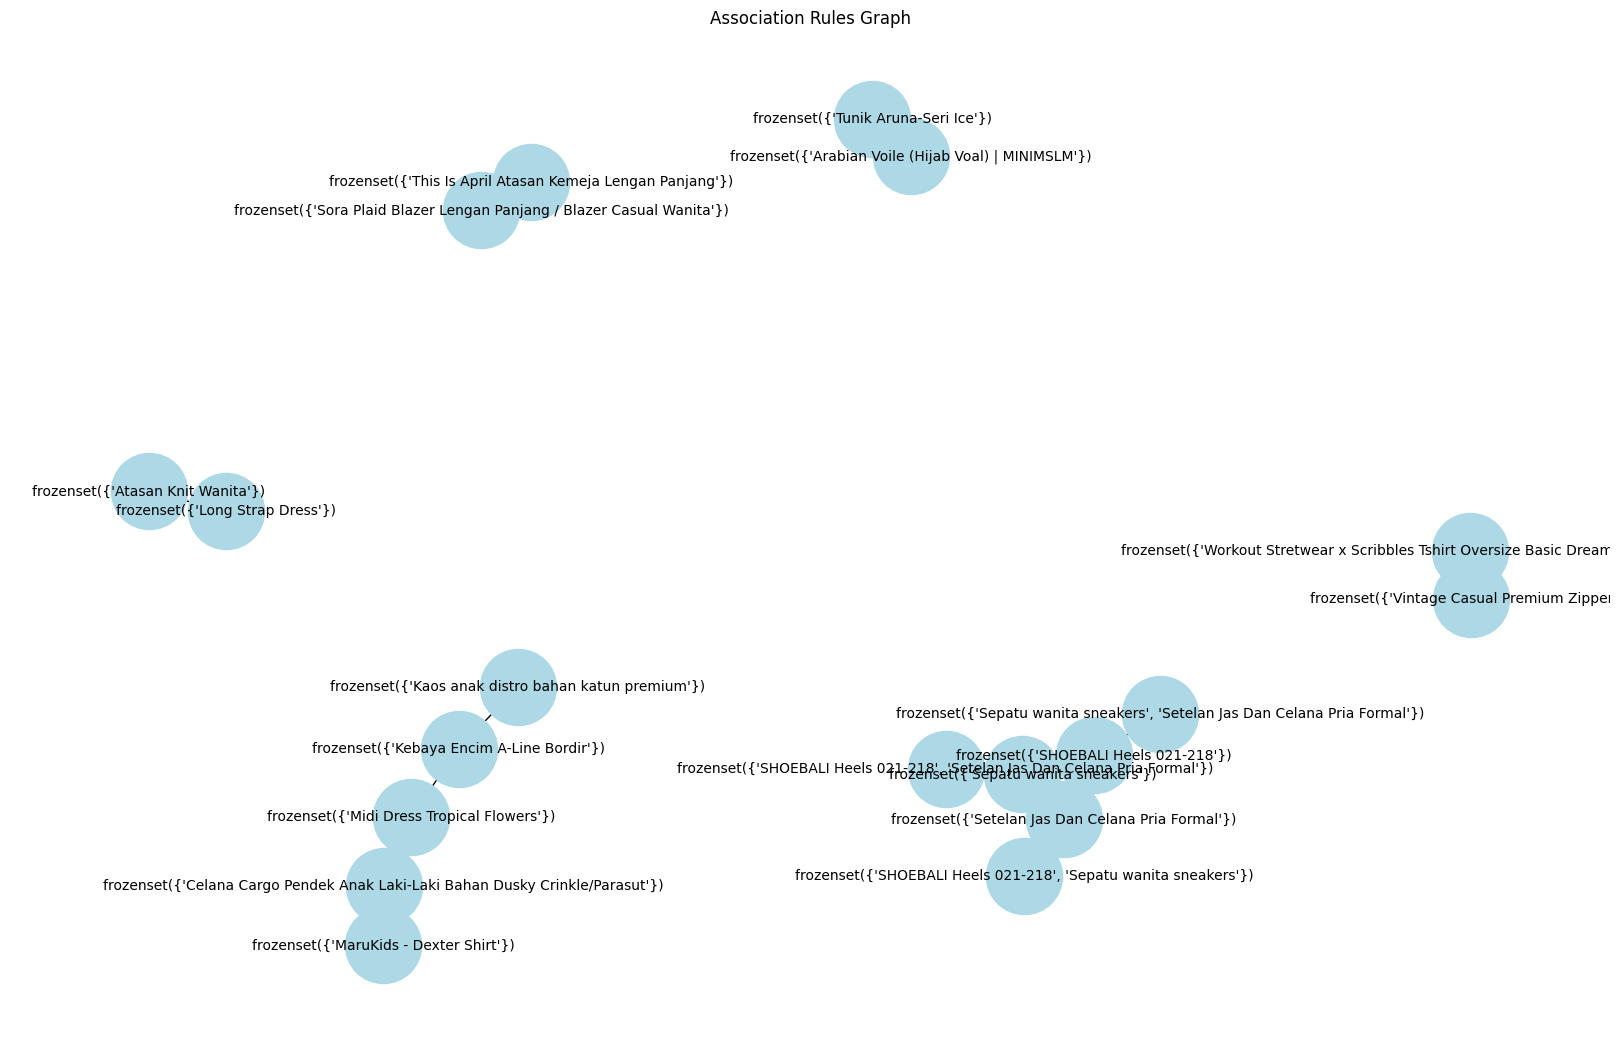

In [143]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.from_pandas_edgelist(rules, 'antecedents', 'consequents')
plt.figure(figsize=(16, 10))
nx.draw(G, with_labels=True, node_size=3000, node_color='lightblue', font_size=10)
plt.title('Association Rules Graph')
plt.show()